# VAE on 8x8 MNIST

In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

# Quick hack to make tb highlighting configurable - https://github.com/ipython/ipython/pull/13756
# from IPython.core.ultratb import VerboseTB
# VerboseTB._tb_highlight = "bg:#039dfc"  # "bg:#039dfc"

try:
    plt.style.use("my_dracula")
except:
    plt.style.use("default")
matplotlib.rcParams['figure.figsize'] = [9, 3]

np.random.seed(23)
tf.random.set_seed(23)
print("TensorFlow Version " + tf.__version__)
print(str(tf.config.list_physical_devices()))

TensorFlow Version 2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## My base implementations tf.keras

### Classes

In [2]:
# dense layer with flexible input shape and activation function passed
class Dense_flex(tf.keras.layers.Layer):
    def __init__(self, out_features, activation=None, name=None):
        super().__init__(name=name)

        self.activation = activation
        self.out_features = out_features

    def build(self, input_shape):
        if self.activation is None:
            initializer = "norm_Xavier"
        else:
            if self.activation._tf_api_names_v1[0] == "nn.relu":
                initializer = "He"
            else:
                initializer = "norm_Xavier"

        input_features = input_shape[-1]

        if initializer == "He":
            # parameter initialization with He initialization for ReLu
            self.w = tf.Variable(tf.random.normal([input_features, self.out_features],
                                                  stddev=np.sqrt(2/input_features)), name="w")
            self.b = tf.Variable(tf.random.normal([self.out_features], stddev=np.sqrt(2/input_features)), name="b")
        elif initializer == "norm_Xavier":
            # initialize weights with normalized Xavier
            xavier = np.sqrt(6)/np.sqrt(input_features + self.out_features)
            self.w = tf.Variable(tf.random.uniform([input_features, self.out_features],
                                                   minval=-xavier, maxval=xavier), name="w")
            self.b = tf.Variable(tf.random.uniform([self.out_features], minval=-xavier, maxval=xavier), name="b")
        else:
            # should not be possible to get here
            print("ERROR INITIALIZER")

    def call(self, x, training=False):
        z = tf.matmul(x, self.w) + self.b
        if self.activation is not None:
            return self.activation(z)
        else:
            return z

### Training

In [3]:
# training function using tf.data structure
# args used to pass n_classes to cross entropy loss for classification
@tf.function
def train(model, data, y, loss, learning_rate):

    with tf.GradientTape() as t:
        current_loss = loss(y, model(data, training=True))

    grad = t.gradient(current_loss, model.variables)

    for g, var in zip(grad, model.variables):
        var.assign_sub(learning_rate * g)

In [4]:
# training loop
# args used to pass n_classes to cross entropy loss for classification
def training_loop(model, dataset, loss, learning_rate=0.01, epochs=10):

    hist_loss = []
    # hist_loss.append(loss(y, model(x)).numpy())

    for epoch in range(epochs):
        # if not epoch % 10:
        #     print(f"Starting {epoch = }")

        # iterate over batches
        epoch_loss = 0
        for step, (x_batch, y_batch) in enumerate(dataset):
            train(model, x_batch, y_batch, loss, learning_rate)
            current_batch_loss = loss(y_batch, model(x_batch, training=True)).numpy()
            epoch_loss += loss(y_batch, model(x_batch, training=True)).numpy()

        hist_loss.append(epoch_loss)

    plt.plot(range(epochs), hist_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training")
    # plt.show()

In [5]:
def cross_entropy_logits(y, logits):
    if logits.shape[-1] == 1:  # case for binary classifier
        y = tf.reshape(y, [-1, 1])
        y = tf.cast(y, tf.float32)
        probs = tf.nn.sigmoid(logits)
        # y_pred = tf.reshape(y_pred, y.shape.as_list())
        return - tf.reduce_mean(y * tf.math.log(probs) + (1. - y) * tf.math.log(1. - probs))
    else:  # multiclass case
        y = tf.cast(y, tf.int8)
        y = tf.one_hot(y, logits.shape[-1], axis=-1)
        probs = tf.nn.softmax(logits)
        return - tf.reduce_mean(y * tf.math.log(probs))

In [6]:
def accuracy(y_true, y_pred):
    pred = np.argmax(y_pred, axis=1)
    right = np.where(pred == y_true, 1, 0)

    return np.sum(right)/right.shape[0]

In [7]:
def loss_batched_dataset(model, loss, dataset):
    pred = []
    y_true = []
    for step, (x_batch, y_batch) in enumerate(dataset):
        pred.append(model(x_batch))
        y_true.append(y_batch)
    return loss(tf.concat(y_true, axis=0), tf.concat(pred, axis=0))

In [8]:
def convert_model_to_functional(model, input_shape=None, name=None):
    if input_shape is None:
        input_shape = model.input_shape

    inputs = tf.keras.Input(shape=input_shape)
    outputs = model.call(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


def model_summary(model, input_shape=None, name=None):
    m = convert_model_to_functional(model, input_shape, name)
    m.summary()


def plot_model(model, input_shape=None, name=None, show_shapes=True, file_to_save=None):
    m = convert_model_to_functional(model, input_shape, name)
    if file_to_save is not None:
        return tf.keras.utils.plot_model(m, file_to_save, show_shapes=show_shapes)
    else:
        return tf.keras.utils.plot_model(m, show_shapes=show_shapes)

## Load data MNIST

In [9]:
IMG_SIZE = 8
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

In [10]:
def show_img_ex(data, label, N=3, idx=None, normalized=True,):
    if idx is None:
        idx = np.random.choice(data.shape[0], N)
    for i in range(N):
        plt.subplot(1, N, i+1)
        if normalized:
            plt.imshow(data[idx[i]], cmap="gray")
        else:
            plt.imshow(data[idx[i]]/255., cmap="gray")
        plt.title(f"Element {idx[i]} - True label: {label[idx[i]]}")
        plt.axis("off")
    plt.tight_layout()

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [12]:
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_digits.shape

(70000, 28, 28, 1)

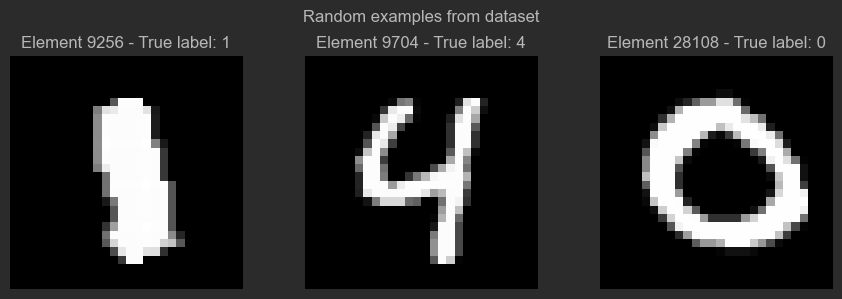

In [13]:
N = 3
rnd = np.random.choice(all_digits.shape[0], N)
plt.suptitle("Random examples from dataset")
show_img_ex(all_digits, all_labels, 3, rnd)
plt.show()

In [14]:
all_digits = resize_and_rescale(all_digits)
all_digits.shape

TensorShape([70000, 8, 8, 1])

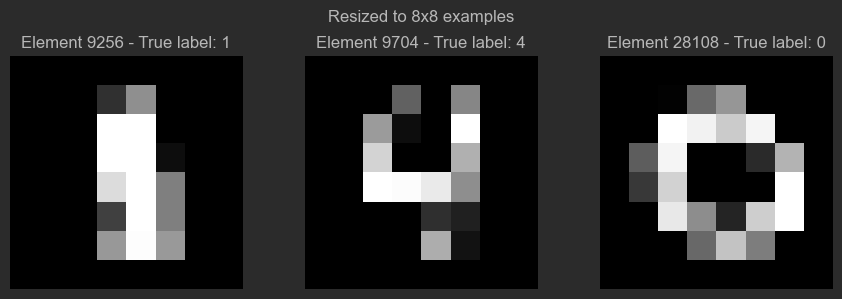

In [15]:
plt.suptitle("Resized to 8x8 examples")
show_img_ex(all_digits, all_labels, 3, rnd)
plt.show()

### All digits dataset

**Tensorflow dataset**:
- class: *"tf.data.Dataset"*
- to create dataset from matrix/tensor/dataframe(?) "*.from_tensor_slices(data)*"
- *".cache()"* -- can improve perormance
- *".shuffle(buffer_size)"*
- *".batch(batch_size)"*
- *".prefetch(tf.data.AUTOTUNE)"* -- allows later elements (batches if batched) to be prepared while the current element is being processed. Can use **<u>*tf.data.AUTOTUNE*</u>** to autotune based on system. **Note: <u>prefetch operates on the elements of the input dataset.</u>** It has no concept of examples vs. batches. examples.prefetch(2) will prefetch two elements (2 examples), while examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).

In [16]:
# batch_size = 64
ds_all = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
ds_all = ds_all.shuffle(buffer_size=1024)  # .batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_all

<ShuffleDataset element_spec=(TensorSpec(shape=(8, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

### Single digit dataset

single_digit.shape = TensorShape([7877, 8, 8, 1])


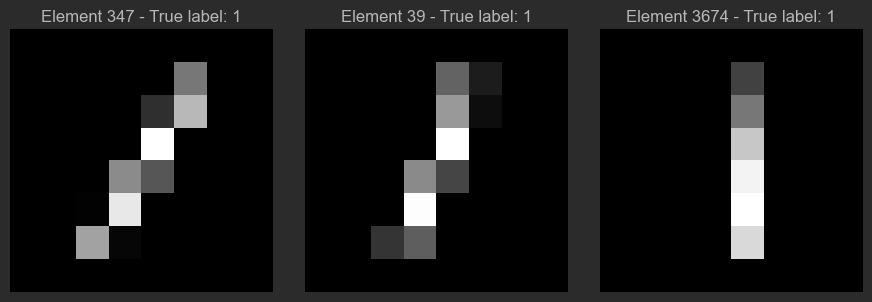

In [17]:
select_label = 1

single_digit = all_digits[all_labels == select_label]
single_label = all_labels[all_labels == select_label]
print(f"{single_digit.shape = }")

show_img_ex(single_digit, single_label)
plt.show()

In [18]:
# batch_size = 64
ds_single = tf.data.Dataset.from_tensor_slices(single_digit)
ds_single = ds_single.shuffle(buffer_size=1024)  # .batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_single

<ShuffleDataset element_spec=TensorSpec(shape=(8, 8, 1), dtype=tf.float32, name=None)>

## VAE on single digit

### Model implementation

#### With my layers

In [19]:
class simple_VAE(tf.keras.Model):
    def __init__(self, latent_dim:int=1, name="VAE-my_layers"):
        super().__init__(name=name)

        self.latent_dim = latent_dim

        # encoder
        self.encoder = tf.keras.Sequential(
            [
                layers.Flatten(),
                Dense_flex(64, activation=tf.nn.relu),
                Dense_flex(32, activation=tf.nn.relu),
                Dense_flex(latent_dim + latent_dim),
            ], name="encoder"
        )

        # decoder
        self.decoder = tf.keras.Sequential(
            [
                Dense_flex(32, activation=tf.nn.relu),
                Dense_flex(64, activation=tf.nn.relu),
                Dense_flex(64),
                layers.Reshape(target_shape=(8, 8, 1))
            ], name="decoder"
        )

    def encode(self, x):
        mean, log_var = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_var

    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=(mean.shape[0], mean.shape[1]))
        return mean + tf.exp(.5 * log_var) * eps

    def sample(self, n_samples:int=1, z=None):
        if z is None:
            z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z)

    def decode(self, z, apply_sigmoid:bool=True):
        if apply_sigmoid:
            return tf.nn.sigmoid(self.decoder(z))
        return self.decoder(z)

    def call(self, x):
        mean, log_var = self.encode(x)
        return self.decode(self.reparametrize(mean, log_var))

In [20]:
test = simple_VAE(1)
# build
test(single_digit[:1])
test.summary()

Model: "VAE-my_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (1, 2)                    6306      
                                                                 
 decoder (Sequential)        (1, 8, 8, 1)              6336      
                                                                 
Total params: 12,642
Trainable params: 12,642
Non-trainable params: 0
_________________________________________________________________


In [21]:
test.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (1, 64)                   0         
                                                                 
 dense_flex (Dense_flex)     (1, 64)                   4160      
                                                                 
 dense_flex_1 (Dense_flex)   (1, 32)                   2080      
                                                                 
 dense_flex_2 (Dense_flex)   (1, 2)                    66        
                                                                 
Total params: 6,306
Trainable params: 6,306
Non-trainable params: 0
_________________________________________________________________


In [22]:
test.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flex_3 (Dense_flex)   (1, 32)                   64        
                                                                 
 dense_flex_4 (Dense_flex)   (1, 64)                   2112      
                                                                 
 dense_flex_5 (Dense_flex)   (1, 64)                   4160      
                                                                 
 reshape (Reshape)           (1, 8, 8, 1)              0         
                                                                 
Total params: 6,336
Trainable params: 6,336
Non-trainable params: 0
_________________________________________________________________


#### With Keras layers

In [23]:
class VAE_keras(tf.keras.Model):
    def __init__(self, latent_dim:int=1, name="VAE-keras_layers"):
        super().__init__(name=name)

        self.latent_dim = latent_dim

        # encoder
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(8, 8, 1)),
                layers.Flatten("channels_last"),
                layers.Dense(64, "relu", kernel_initializer="he_uniform"),
                layers.Dense(32, "relu", kernel_initializer="he_uniform"),
                layers.Dense(latent_dim + latent_dim),
            ], name="encoder"
        )

        # decoder
        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(latent_dim,)),
                layers.Dense(32, "relu", kernel_initializer="he_uniform"),
                layers.Dense(64, "relu", kernel_initializer="he_uniform"),
                layers.Dense(64),
                layers.Reshape(target_shape=(8, 8, 1))
            ], name="decoder"
        )

    def encode(self, x):
        mean, log_var = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, log_var

    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=(mean.shape[0], mean.shape[1]))
        return mean + tf.exp(.5 * log_var) * eps

    def sample(self, n_samples:int=1, z=None):
        if z is None:
            z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z)

    def decode(self, z, apply_sigmoid:bool=True):
        if apply_sigmoid:
            return tf.nn.sigmoid(self.decoder(z))
        return self.decoder(z)

    def call(self, x):
        mean, log_var = self.encode(x)
        return self.decode(self.reparametrize(mean, log_var))

In [24]:
test = VAE_keras(1)
# build
test(single_digit[:1])
test.summary()

Model: "VAE-keras_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 2)                 6306      
                                                                 
 decoder (Sequential)        (None, 8, 8, 1)           6336      
                                                                 
Total params: 12,642
Trainable params: 12,642
Non-trainable params: 0
_________________________________________________________________


In [25]:
test.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 6,306
Trainable params: 6,306
Non-trainable params: 0
_________________________________________________________________


In [26]:
test.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                64        
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 1)           0         
                                                                 
Total params: 6,336
Trainable params: 6,336
Non-trainable params: 0
_________________________________________________________________


### Model fitting

#### Training functions

Train by maximizing ELBO with single sample estimate for the expectations.

In [27]:
def log_normal_pdf(x, mean, log_var, red_axis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(- .5 * ((x - mean)**2. * tf.exp(-log_var) + log_var + log2pi), axis=red_axis)

In [28]:
# negative elbo to minimize
def compute_elbo_vae(model, x):
    mean, log_var = model.encode(x)
    z = model.reparametrize(mean, log_var)
    x_logit = model.decode(z, apply_sigmoid=False)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logit)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1,2,3])
    logp_z = log_normal_pdf(z, 0., 0.)  # log_var = 0 in log_normal == var = 1 in normal
    logqz_x = log_normal_pdf(z, mean, log_var)

    return -tf.reduce_mean(logpx_z + logp_z - logqz_x)

In [29]:
# like my implementation, but using keras optimizer class to update the model
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as t:
        loss = compute_elbo_vae(model, x)

    gradients = t.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [30]:
def training_vae(model, dataset, optimizer, epochs, starting_epoch=0):
    loss = []
    for epoch in range(epochs):
        start_time = time.time()

        for x_batch in dataset:
            train_step(model, x_batch, optimizer)
            loss.append(compute_elbo_vae(model, x_batch))

        print(f"Epoch {epoch+starting_epoch+1} completed in {time.time()-start_time:.2f}s")

    plt.plot(loss)
    plt.title("Batch loss")
    plt.ylabel("- ELBO")
    plt.xlabel("Mini-batch")

In [31]:
def generate_imgs(model, test_sample=None, n_per_sample=3):
    if test_sample is None:
        imgs = model.sample(n_per_sample)
        plt.suptitle("Generated imgs from p(z)")
        for i in range(n_per_sample):
            plt.subplot(1, n_per_sample+1, i+1)
            plt.imshow(imgs[i], cmap="gray")
            plt.axis("off")
        plt.tight_layout()
    else:
        M = test_sample.shape[0]
        N = M * (n_per_sample + 1)
        for i in range(M):
            for j in range(n_per_sample + 1):
                plt.subplot(M, n_per_sample+1, i*(n_per_sample+1) + j + 1)
                if j == 0:
                    img = test_sample[i]
                    plt.title("Input img")
                else:
                    img = model(test_sample[i].numpy().reshape(1,8,8,1))[0]
                    plt.title("Generated img")
                plt.imshow(img, cmap="gray")
                plt.axis("off")
        plt.tight_layout()

def get_random_samples(data, n):
    idx = np.random.choice(data.shape[0], n)
    return tf.constant(np.take(data, idx, axis=0))

#### Fitting

In [32]:
batch_size = 32
dataset = ds_single.batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 8, 8, 1), dtype=tf.float32, name=None)>

In [33]:
epochs = 1
latent_dim = 1

model = simple_VAE(latent_dim)
model(single_digit[:1])  # to build model and initialize parameters
optimizer = tf.keras.optimizers.Adam(1e-3)
optimizer.build(model.trainable_variables)

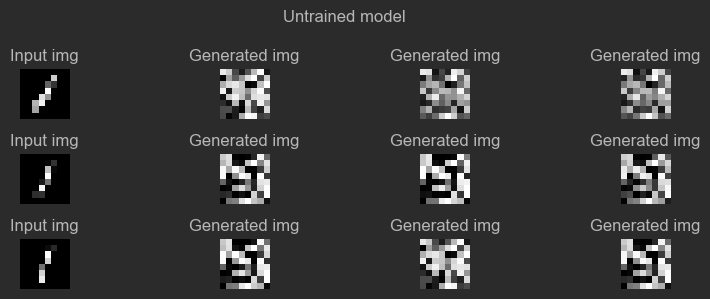

In [34]:
plt.suptitle("Untrained model")
generate_imgs(model, get_random_samples(single_digit, 3))
plt.show()

Epoch 1 completed in 4.43s


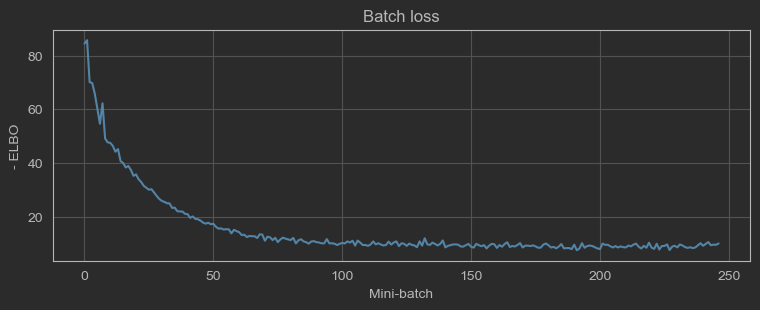

In [35]:
training_vae(model, dataset, optimizer, epochs)

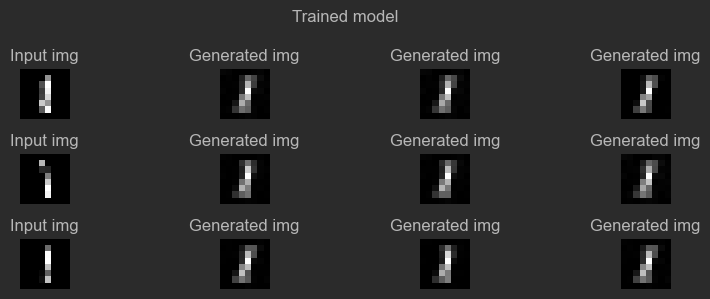

In [36]:
plt.suptitle("Trained model")
generate_imgs(model, get_random_samples(single_digit, 3))
plt.show()

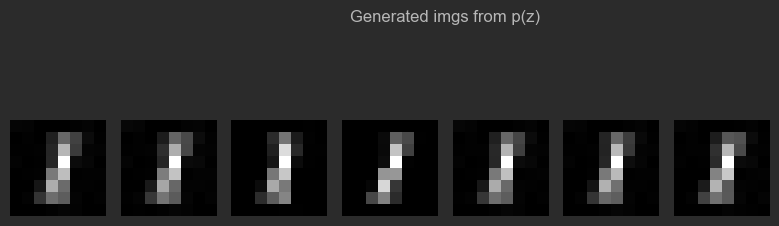

In [37]:
plt.suptitle("Trained model")
generate_imgs(model, n_per_sample=7)
plt.show()

## Conditional VAE on all digits

### Model implementation

In [38]:
class Conditional_VAE(tf.keras.Model):
    def __init__(self, latent_dim:int=1, classes=10, name="Conditional_VAE"):
        super().__init__(name=name)

        self.latent_dim = latent_dim
        self.classes = classes

        condition = keras.Input(shape=(classes,), name="condition")

        # encoder
        encoder_input = keras.Input(shape=(8,8,1), name="img")
        x = layers.Flatten("channels_last")(encoder_input)
        x = layers.Concatenate(axis=-1)([x, condition])
        x = layers.Dense(64, "relu", kernel_initializer="he_uniform")(x)
        x = layers.Dense(32, "relu", kernel_initializer="he_uniform")(x)
        encoder_output = layers.Dense(latent_dim + latent_dim)(x)
        self.encoder = keras.Model([encoder_input, condition], encoder_output, name="encoder")

        # decoder
        decoder_input = keras.Input(shape=(latent_dim,))
        x = layers.Concatenate(axis=-1)([decoder_input, condition])
        x = layers.Dense(32, "relu", kernel_initializer="he_uniform")(x)
        x = layers.Dense(64, "relu", kernel_initializer="he_uniform")(x)
        x = layers.Dense(64)(x)
        decoder_output = layers.Reshape(target_shape=(8, 8, 1))(x)
        self.decoder = keras.Model([decoder_input, condition], decoder_output, name="decoder")


    def encode(self, x, label):
        # better to one hot the labels on the dataset instead of in model
        one_hot_label = tf.one_hot(label, self.classes, axis=-1)
        mean, log_var = tf.split(self.encoder([x, one_hot_label]), num_or_size_splits=2, axis=1)
        return mean, log_var

    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=(mean.shape[0], mean.shape[1]))
        return mean + tf.exp(.5 * log_var) * eps

    def sample(self, n_samples:int=1, label=None, z=None):
        if label is None:
            label = tf.random.uniform(shape=(n_samples,), minval=0, maxval=self.classes, dtype=tf.int32)
        if z is None:
            z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z, label)

    def decode(self, z, label, apply_sigmoid:bool=True):
        one_hot_label = tf.one_hot(label, self.classes, axis=-1)
        if apply_sigmoid:
            return tf.nn.sigmoid(self.decoder([z, one_hot_label]))
        return self.decoder([z, one_hot_label])

    def call(self, x, label):
        mean, log_var = self.encode(x, label)
        return self.decode(self.reparametrize(mean, log_var), label)

In [39]:
test = Conditional_VAE(1)
# build
test(single_digit[:1], single_label[:1])
test.summary()

Model: "Conditional_VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 2)                 6946      
                                                                 
 decoder (Functional)        (None, 8, 8, 1)           6656      
                                                                 
Total params: 13,602
Trainable params: 13,602
Non-trainable params: 0
_________________________________________________________________


In [40]:
test.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 64)           0           ['img[0][0]']                    
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 74)           0           ['flatten_3[0][0]',              
                                                                  'condition[0][0]']        

In [41]:
test.decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 11)           0           ['input_3[0][0]',                
                                                                  'condition[0][0]']              
                                                                                                  
 dense_9 (Dense)                (None, 32)           384         ['concatenate_1[0][0]']    

### Model fitting

#### Training functions

In [42]:
def log_normal_pdf(x, mean, log_var, red_axis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(- .5 * ((x - mean)**2. * tf.exp(-log_var) + log_var + log2pi), axis=red_axis)

In [43]:
# negative elbo to minimize
def compute_elbo_cvae(model, x, y):
    mean, log_var = model.encode(x, y)
    z = model.reparametrize(mean, log_var)
    x_logit = model.decode(z, y, apply_sigmoid=False)
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logit)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1,2,3])
    logp_z = log_normal_pdf(z, 0., 0.)  # log_var = 0 in log_normal == var = 1 in normal
    logqz_x = log_normal_pdf(z, mean, log_var)

    return -tf.reduce_mean(logpx_z + logp_z - logqz_x)

In [44]:
# like my implementation, but using keras optimizer class to update the model
@tf.function
def train_step_cvae(model, x, y, optimizer):
    with tf.GradientTape() as t:
        loss = compute_elbo_cvae(model, x, y)

    gradients = t.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [45]:
def training_cvae(model, dataset, optimizer, epochs, starting_epoch=0):
    loss = []
    for epoch in range(epochs):
        start_time = time.time()

        for step, (x_batch, y_batch) in enumerate(dataset):
            train_step_cvae(model, x_batch, y_batch, optimizer)
            loss.append(compute_elbo_cvae(model, x_batch, y_batch))

        print(f"Epoch {epoch+starting_epoch+1} completed in {time.time()-start_time:.2f}s")

    plt.plot(loss)
    plt.title("Batch loss")
    plt.ylabel("- ELBO")
    plt.xlabel("Mini-batch")

In [46]:
def generate_imgs_cvae(model, test_sample=None, test_label=None, n_per_sample=3, gen_label=None):
    if test_sample is None:
        if gen_label is None:
            gen_label = int(np.random.uniform(0, 10))

        plt.suptitle(f"Generated imgs from p(z|class={gen_label})")
        for i in range(n_per_sample):
            img = model.sample(label=np.array(gen_label, dtype=np.uint8).reshape(-1))[0]
            plt.subplot(1, n_per_sample+1, i+1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
        plt.tight_layout()
    else:
        M = test_sample.shape[0]
        N = M * (n_per_sample + 1)
        for i in range(M):
            for j in range(n_per_sample + 1):
                plt.subplot(M, n_per_sample+1, i*(n_per_sample+1) + j + 1)
                if j == 0:
                    img = test_sample[i]
                    plt.title(f"Input img: {test_label[i]}")
                else:
                    img = model(test_sample[i].numpy().reshape(1,8,8,1), test_label[i].numpy().reshape(-1))[0]
                    plt.title("Generated img")
                plt.imshow(img, cmap="gray")
                plt.axis("off")
        plt.tight_layout()

def get_random_samples_and_labels(data, labels, n):
    idx = np.random.choice(data.shape[0], n)
    return tf.constant(np.take(data, idx, axis=0)), tf.constant(np.take(labels, idx, axis=0))

#### Fitting

In [47]:
batch_size = 128
dataset = ds_all.batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [48]:
epochs = 2
latent_dim = 2

model = Conditional_VAE(latent_dim)
model(all_digits[:1], all_labels[:1])  # to build model and initialize parameters
optimizer = tf.keras.optimizers.Adam(1e-3)
optimizer.build(model.trainable_variables)

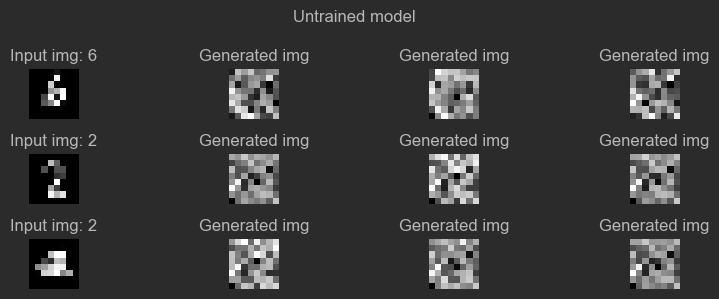

In [49]:
plt.suptitle("Untrained model")
generate_imgs_cvae(model, *get_random_samples_and_labels(all_digits, all_labels, 3))
plt.show()

Epoch 1 completed in 8.51s
Epoch 2 completed in 6.78s


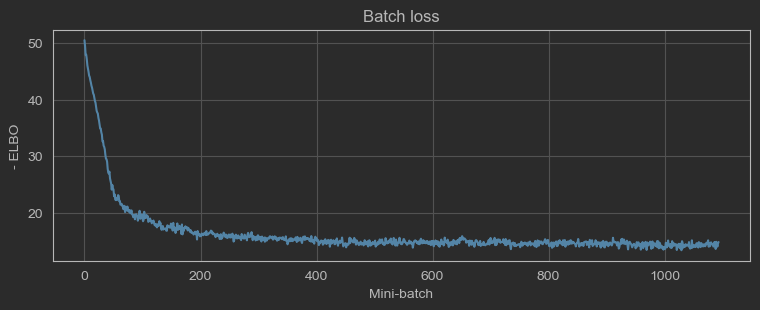

In [50]:
training_cvae(model, dataset, optimizer, epochs)

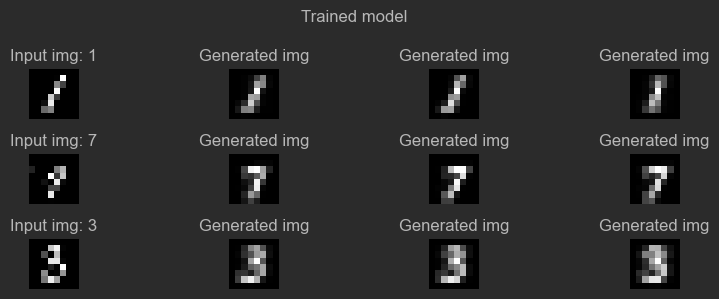

In [51]:
plt.suptitle("Trained model")
generate_imgs_cvae(model, *get_random_samples_and_labels(all_digits, all_labels, 3))
plt.show()

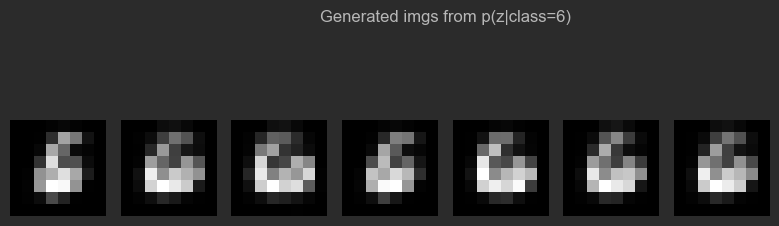

In [52]:
plt.suptitle("Trained model")
generate_imgs_cvae(model, n_per_sample=7)
plt.show()

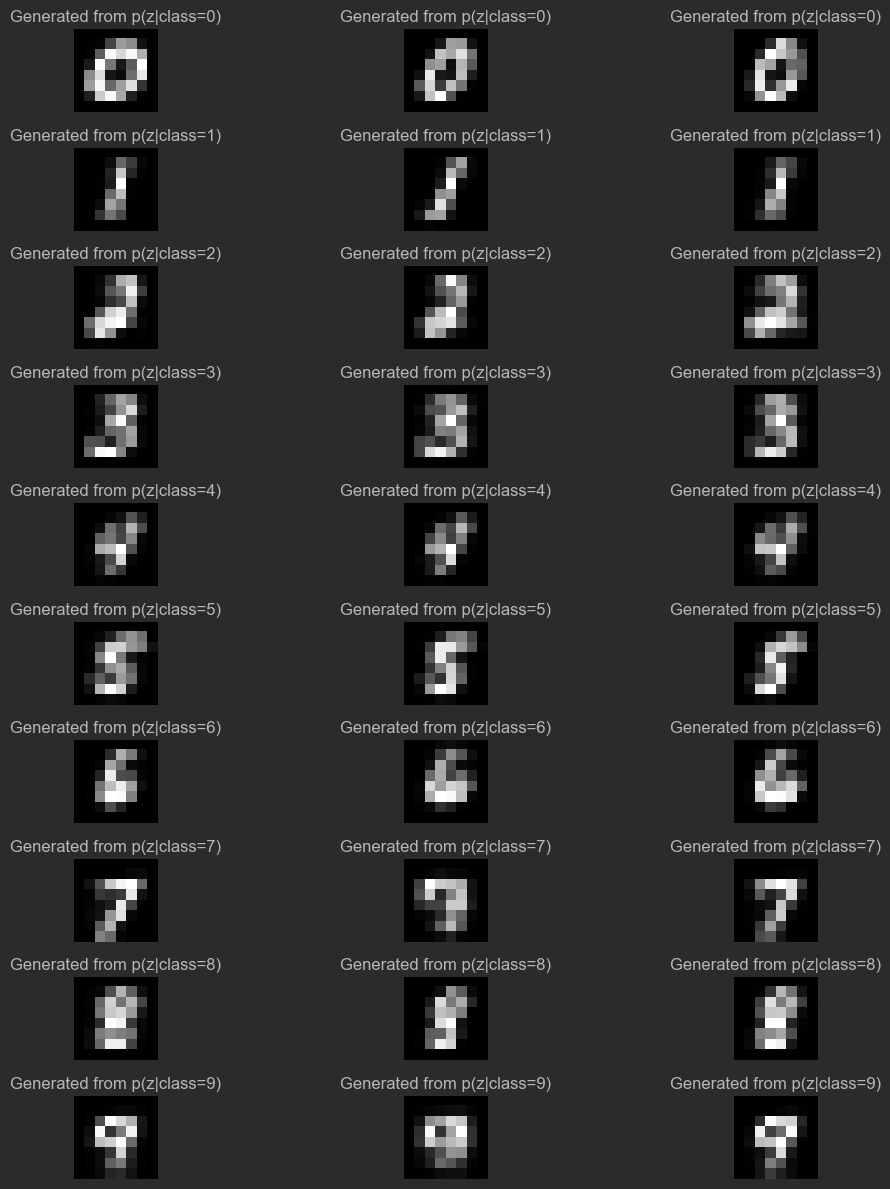

In [53]:
n_samples = 3
classes = 10
plt.figure(figsize=(12,12))
for i in range(classes):
    for j in range(n_samples):
        plt.subplot(classes, n_samples, i*n_samples + j+1)
        img = model.sample(label=np.array(i, dtype=np.uint8).reshape(-1))[0]
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Generated from p(z|class={i})")

plt.tight_layout()
plt.show()